

Spatial autocorrelation is a statistical concept that measures how similar values of a variable are based on their proximity to each other on a map. Positive spatial autocorrelation means that geographically nearby values of a variable tend to be similar on a map: high values tend to be located near high values, and low values near low values.
By analyzing the spatial distribution of potential hazards, insurers can identify patterns and trends that might not be apparent when looking at data in isolation. This allows for more accurate risk assessment and pricing, ensuring that premiums are set appropriately based on the actual risk in different geospatial cohorts. Additionally, understanding geospatial correlations can help insurers develop targeted strategies for risk mitigation and improve their overall portfolio management. This approach ultimately leads to better financial stability for the insurer and fairer pricing for policyholders.

It is well known that tornadoes frequently occur in "Tornado Alley", a loosely defined location of states including Texas, Louisiana, Oklahoma, Kansas, South Dakota, Iowa and Nebraska. In what follows, we analyze tornado events from 2008-Present and estimate the global spatial autocorrelation for these events using Moran's I, and determie if the results align with our prior assumptions of positive spatial autocorrelation. 

The National Oceanic and Atmospheric Administration (NOAA) documents the occurrence of storms and other significant weather phenomena having sufficient intensity to cause loss of life, injuries, significant property damage, and/or disruption to commerce. The database for events going back to 1950 is available for download [here](https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/), and serves as the starting point for our analysis. U.S. state shapefiles are available [here](https://www2.census.gov/geo/tiger/TIGER2024/STATE/).




In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

np.set_printoptions(suppress=True, precision=5)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Storm data. 
noaa_path = "F:/actu-s/CatastropheData/NOAA_Storm_Data/noaa-storm-data-1950-2024.csv.gz"

# US state shapefiles. 
state_shp = "C:/Users/i103455/Downloads/tl_2024_us_state.zip"



<br>

We begin by reading in the the NOAA storm event data and filter down to tornado events from 2008-present. We also remove lower severity tornado events based on the [Enhanced Fujita Scale](https://en.wikipedia.org/wiki/Enhanced_Fujita_scale):


**Enhanced Fujita scale**:

- **EFU**: Unknown
- **EF0**: 65-85 mph (Light)
- **EF1**: 86-110 mph (Moderate)
- **EF2**: 111-135 mph (Cosiderable)
- **EF3**: 136-165 mph (Severe)
- **EF4**: 166-200 mph (Devestating)
- **EF5**: >200 mph (Incredible)

Events with TOR_F_SCALE  =  "F0", "F1", "EF0", "EF1" are excluded. 

In [2]:

# Obtained here: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/
dfstorms_all = pd.read_csv(noaa_path, low_memory=False)

keep_events = [
    "F2", "EF2", "F3", "F4", "F5", "EF3", "EF4", "EF5"
]

dfstorms = dfstorms_all[
    (dfstorms_all.YEAR>=2008) & 
    (dfstorms_all.EVENT_TYPE=="Tornado") &
    (dfstorms_all.TOR_F_SCALE.isin(keep_events))
]

dfstorms = (
    dfstorms
    .dropna(subset=["BEGIN_LAT", "BEGIN_LON", "TOR_F_SCALE"])
    .reset_index(drop=True)
)

# Filter storms to lower 48 states.
storms = gpd.GeoDataFrame(
    dfstorms,
    geometry=gpd.points_from_xy(dfstorms.BEGIN_LON, dfstorms.BEGIN_LAT),
    crs="EPSG:4326"
)

storms = storms[["EVENT_ID", "TOR_F_SCALE", "geometry"]]
storms = storms.cx[-125:65, 24.6:50].reset_index(drop=True)

print(f"Number of storms: {storms.shape}")

storms.head()


Number of storms: (2917, 3)


,EVENT_ID,TOR_F_SCALE,geometry
0,105611,EF2,POINT (-96.30000 43.14210)
1,80215,EF2,POINT (-86.01250 37.66250)
2,80216,EF2,POINT (-85.77590 37.69650)
3,80218,EF2,POINT (-85.06490 37.68890)
4,79065,EF2,POINT (-85.38120 37.81130)



<br>

Reviewing the distribution of F and EF events:

In [3]:

storms.TOR_F_SCALE.value_counts()


TOR_F_SCALE
EF2    2197
EF3     579
EF4     128
EF5      13
Name: count, dtype: int64


<br> 

Load the state shapefile and overlay retained tornado events:


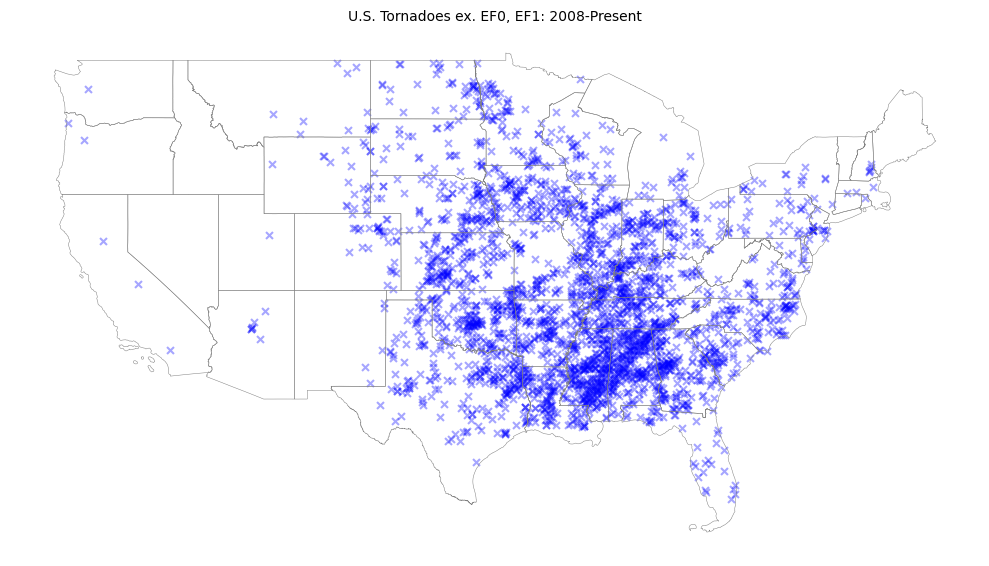

In [4]:

import os
import sys

# This suppresses `Cannot find header.dxf (GDAL_DATA is not defined)` warning.
os.environ['GDAL_DATA'] = os.path.join(f'{os.sep}'.join(sys.executable.split(os.sep)[:-1]), 'Library', 'share', 'gdal')

# Filter to lower 48 states. 
states = gpd.read_file(state_shp).to_crs("EPSG:4326")[["NAME", "ALAND", "geometry"]]
states = states.cx[-125:65, 24.6:50].reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.set_title("U.S. Tornadoes ex. EF0, EF1: 2008-Present", fontsize=10)
states.boundary.plot(ax=ax, edgecolor="grey", linewidth=.35)
storms.plot(ax=ax, color="blue", marker="x", markersize=25, alpha=.35)
ax.axis("off")
plt.show()



<br>

There are more tornadoes in the mid-south and southeast than expected. Nonetheless, there exists a clear spatial pattern to the events: Tornadoes do not appear randomly distributed over the lower 48 states. We can use Global Moran's I to gauge the degree of spatial autocorrelation inherent in the data. 

In order to assign each tornado to a state, a spatial join is performed where each event is assigned to the state polygon that encloses it:


In [5]:

dfn = (
    states
    .sjoin(storms)
    .groupby(["NAME", "ALAND"], as_index=False).size()
    .rename({"size": "n"}, axis=1)
)

# Merge dfn with states to get back geometry associated with each state.
# gdf will be a GeoDataFrame.
gdf = (
    states
    .merge(dfn, on=["NAME", "ALAND"], how="left")
    .fillna(value={"n": 0})[["NAME", "ALAND", "n", "geometry"]]
    .sort_values("NAME")
    .reset_index(drop=True)
)

print(f"Total number of events: {gdf['n'].sum()}")

gdf.head(20)


Total number of events: 2917.0


,NAME,ALAND,n,geometry
0,Alabama,131185561946,253.0,"POLYGON ((-85.12733 31.76256, -85.12753 31.762..."
1,Arizona,294366118294,7.0,"POLYGON ((-110.75069 37.00301, -110.74193 37.0..."
2,Arkansas,134658517854,133.0,"POLYGON ((-90.95577 34.11871, -90.95451 34.117..."
3,California,403673433805,3.0,"MULTIPOLYGON (((-119.99987 41.18397, -119.9998..."
4,Colorado,268418973518,31.0,"POLYGON ((-105.15504 36.99526, -105.15543 36.9..."
5,Connecticut,12541999507,0.0,"POLYGON ((-72.52790 41.17777, -72.55156 41.173..."
6,Delaware,5046692239,4.0,"POLYGON ((-75.50949 39.68652, -75.50942 39.686..."
7,District of Columbia,158316181,0.0,"POLYGON ((-77.11975 38.93435, -77.11886 38.935..."
8,Florida,138965379385,40.0,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
9,Georgia,149485762701,153.0,"POLYGON ((-81.09538 31.52098, -81.09710 31.519..."


<br>

Visualizing the number of tornadoes by state:

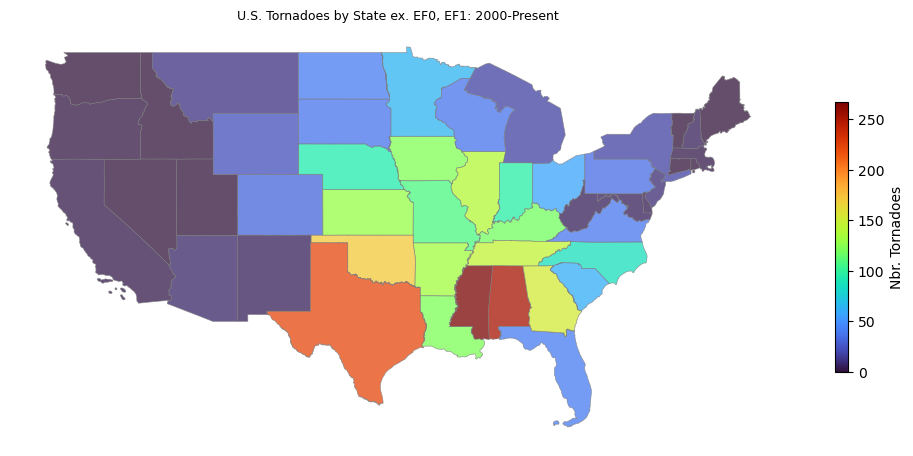

In [6]:

cmap = "turbo"

fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.set_title("U.S. Tornadoes by State ex. EF0, EF1: 2000-Present", fontsize=9)
gdf.plot(
    ax=ax, column="n", edgecolor="gray", linewidth=.50, 
    cmap=cmap, alpha=.750, legend=True,
    legend_kwds={"label": "Nbr. Tornadoes", "orientation": "vertical", "shrink": .35}
    )
ax.axis("off")
plt.show()



<br>

Texas appears to have a large number of events, but this may be due to the fact that Texas has the largest land area of any state in the lower 48. If tornadoes were randomly distributed, we wouldn’t expect to see clusters of similar values on the map. However, our attention is drawn to south central and south eastern states, where hues are brighter compared with coastal regions. 

Let's take a look at number of events divided by ALAND:

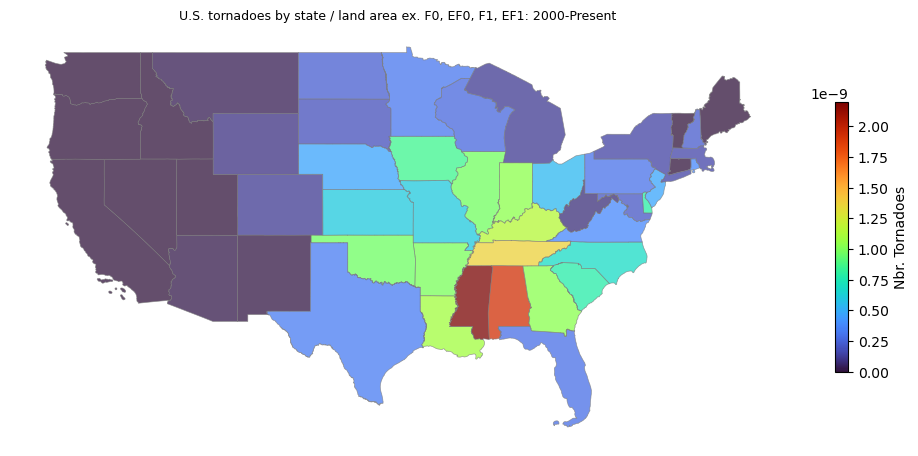

In [17]:

cmap = "turbo"

gdf["n_div_ALAND"] = gdf["n"] / gdf["ALAND"]

fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.set_title("U.S. tornadoes by state / land area ex. F0, EF0, F1, EF1: 2000-Present", fontsize=9)
gdf.plot(
    ax=ax, column="n_div_ALAND", edgecolor="gray", linewidth=.50, 
    cmap=cmap, alpha=.750, legend=True,
    legend_kwds={"label": "Nbr. Tornadoes", "orientation": "vertical", "shrink": .35}
    )
ax.axis("off")
plt.show()



<br>




<br>

Mississippi and Alabama are consistent with the raw counts choropleth, but Texas doesn't stand out as much when normalized by total land area. Nonetheless, raw tornado counts are used for the subsequent analysis. 

<br>


### Spatial Weights

In order to quantify spatial autocorrelation, it is first necessary to define the idea of closeness or proximity between geospatial units. 
The spatial weights matrix $W$ encodes the spatial relationships between different locations in a dataset in much the same way as an adjacency matrix used in Graph Theory and Network Science. For a dataset with $N$ geospatial units, $W$ 
will have dimension $N \times N$, with 0's along the main diagonal. Each element $w_{ij}$ represents the spatial relationship between locations $i$ and $j$. The relationship can be based on distance, contiguity or some other criteria. More information of spatial weights matrices is available [here](https://geographicdata.science/book/notebooks/04_spatial_weights.html). 
  
We use the Queen contiguity matrix, which is a row-standardized, symmetric matrix that indicates whether two areas are neighbors based on whether they share a vertex or edge. The value at cell $w_{i,j}$ is 1 if $i$ and $j$ are neighbors and 0 otherwise. Using PySAL, the weights matrix with Queen contiguity can be created as follows:


In [20]:

from pysal.lib import weights

# Queen contiguity.
wq = weights.contiguity.Queen.from_dataframe(gdf, use_index=True)

# Convert to dense matrix for viewing:
W = pd.DataFrame(*wq.full()).astype(int)

W


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0



<br>

The number of neighbors for each state is available in `wq`'s `cardinalities` attribute:


In [9]:

wq.cardinalities


{0: 4,
 1: 5,
 2: 6,
 3: 3,
 4: 7,
 5: 3,
 6: 3,
 7: 2,
 8: 2,
 9: 5,
 10: 6,
 11: 6,
 12: 4,
 13: 6,
 14: 4,
 15: 7,
 16: 3,
 17: 1,
 18: 5,
 19: 5,
 20: 5,
 21: 5,
 22: 4,
 23: 8,
 24: 4,
 25: 6,
 26: 5,
 27: 3,
 28: 3,
 29: 5,
 30: 6,
 31: 4,
 32: 3,
 33: 5,
 34: 6,
 35: 4,
 36: 6,
 37: 3,
 38: 2,
 39: 6,
 40: 8,
 41: 4,
 42: 6,
 43: 3,
 44: 6,
 45: 2,
 46: 5,
 47: 4,
 48: 6}


<br>

`gdf` is sorted by NAME, so index 0 represents Alabama, index 1 = Arizona, etc. Iowa is at index 13. The columns with value 1 for row index 13 represent Iowa's neighbors in terms of Queen contiguity:

In [10]:

iowa = W.loc[13]

iowa_neighbor_indices = iowa[iowa==1].index

iowa_neighbor_names = gdf.loc[iowa_neighbor_indices, "NAME"]

iowa_neighbor_names


11        Illinois
21       Minnesota
23        Missouri
25        Nebraska
39    South Dakota
47       Wisconsin
Name: NAME, dtype: object


<br>

Spatial lag calculates the average number of tornadoes for a given state's neighbors, and assigns the result to the state:


In [21]:

# Row standardized weights.
wq.transform = "r"

lag = weights.lag_spatial(wq, gdf["n"])

gdf["lag"] = lag




<br>

For Iowa, the spatial lag is 79.83. If we compute the average number of tornadoes from Illinois, Minnesota, Missouri, Nebraska, South Dakota and Wisconsin, we should get 79.83:

In [22]:

actual = gdf.loc[iowa_neighbor_indices, "n"].mean()

print(f"Iowa spatial lag - actual / expected: {actual:.2f} / 79.83")


Iowa spatial lag - actual / expected: 79.83 / 79.83



<br> 

Visualizing the spatial lag can provide further insight into the underlying process. It tends to smooth spatial data, making it easier to identify patterns and trends:


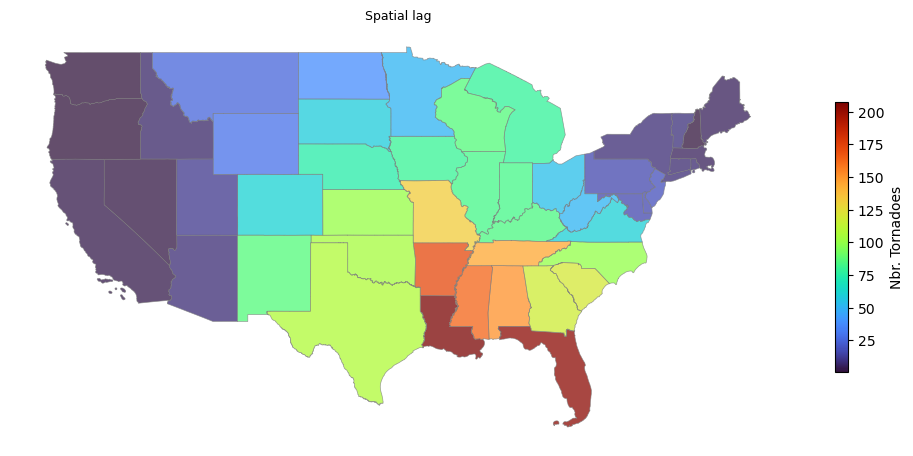

In [13]:

cmap = "turbo"

fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.set_title("Spatial lag", fontsize=9)
gdf.plot(
    ax=ax, column="lag", edgecolor="gray", linewidth=.50, 
    cmap=cmap, alpha=.750, legend=True,
    legend_kwds={"label": "Nbr. Tornadoes", "orientation": "vertical", "shrink": .35}
    )
ax.axis("off")
plt.show()



<br>

## Global Moran's I

Now that we've defined the spatial weights matrix, it is straightforward to quantify spatial autocorrelation. 
Global Moran's I is a measure of the overall clustering of spatial data, defined as

$$
I = \frac{N}{W} \frac{\sum_{i=1}^{N} \sum_{j=1}^{N} w_{ij}(x_{i} - \bar{x})(x_{j} - \bar{x})}{\sum_{i=1}^{N} (x_{i} - \bar{x})^{2}},
$$


where

- $N$: The number of spatial units, 49 in our case (lower 48 + District of Columbia)
- $W$: The sum of values in the spatial weights matrix
- $x$: The variable of interest (tornadoes)
- $\bar{x}$: The global mean of $x$ over all spatial units
- $w_{ij}$: Elements of the spatial weights matrix which encodes spatial interaction

<br>

We'll again rely on Queen contiguity. We first compute Global Moran's I using the formula above, then compare the result with the value returned by PySAL.

In [23]:

wq = weights.contiguity.Queen.from_dataframe(gdf, use_index=True)
W = pd.DataFrame(*wq.full()).values

# Computing Moran's I manually. 
N = gdf.shape[0]

# Average number tornadoes over all states.
xbar = gdf["n"].mean()

# Denominator of Moran's I.
denom = np.sum((gdf["n"] - xbar)**2)

# Update numerator at each iteration.
numer = 0

for i in range(N):
    x_i = gdf.at[i, "n"]
    for j in range(N):
        x_j = gdf.at[j, "n"]
        w_ij = W[i, j]
        numer+=w_ij * (x_i - xbar) * (x_j - xbar)
        

# Compute Global Moran's I.
I1 = (N / W.sum().sum()) * numer / denom

print(f"Manual calculation of Global Moran's I: {I1:.2f}.")


Manual calculation of Global Moran's I: 0.60.



<br>

Using PySAL:


In [24]:

from esda.moran import Moran

I2 = Moran(gdf["n"].values,  wq)

print(f"PySAL calculation of Global Moran's I: {I2.I:.2f}.")


PySAL calculation of Global Moran's I: 0.61.



Pretty close. 

As a rule of thumb:

- If $I$ is above $\frac{-1}{N - 1}$, there exists positive spatial correlation (values are clustered)
- If $I$ is below $\frac{-1}{N - 1}$, there exists negative spatial correlation (neighboring values are dissimilar)
- If $I \approx \frac{-1}{N-1}$, there exists no spatial correlation

<br>

The significance of a correlation in Moran's I is determined by the z-score and p-value, assuming an expected value of $-1 / (N - 1)$. The null hypothesis states that tornadoes are spatially uncorrelated. PySAL returns the p-value of Global Moran's I under the normality assumption:

In [25]:

print(f"PySAL Global Moran's I p-value: {I2.p_norm}")


PySAL Global Moran's I p-value: 3.106619400835348e-11



Which suggests it is very unlikely that the observed degree of clustering of tornadoes arose by chance.  


There are many other techniques that can be used to assess spatial autocorrelation. These will be explored in a future post. 